In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

The shape of the mitbih_train is :  (87554, 188)
The shape of the mitbih_test is :  (21892, 188)
The last time value is :  1488.0


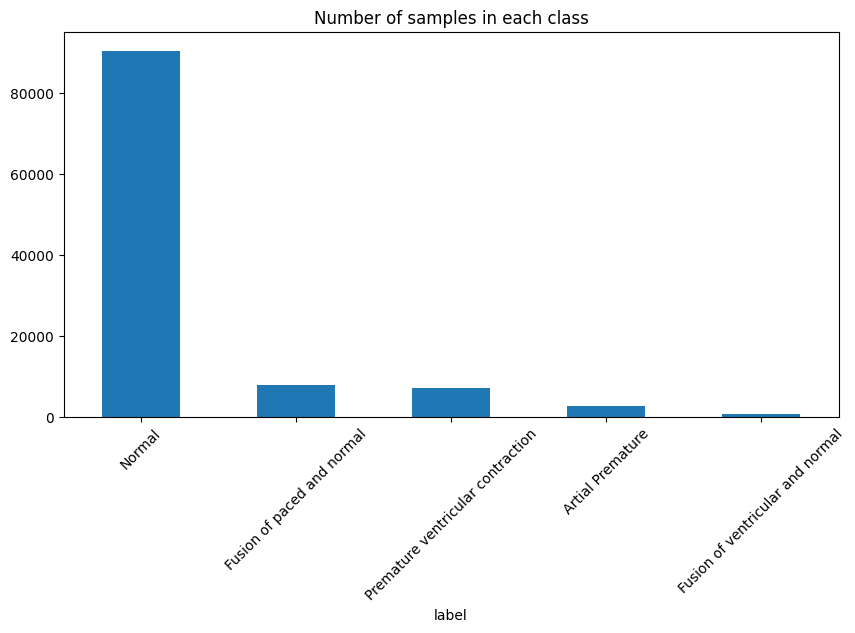

In [2]:
df_mitbih_train = pd.read_csv("mitbih_train.csv", header = None)
df_mitbih_test = pd.read_csv("mitbih_test.csv", header = None)

# print shapes of the dataframes
print("The shape of the mitbih_train is : ", df_mitbih_train.shape)
print("The shape of the mitbih_test is : ", df_mitbih_test.shape)

df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)
df_mitbih.rename(columns={187: 'label'}, inplace=True)

id_to_label = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}
#df_mitbih['label'] = df_mitbih.iloc[:, -1].map(id_to_label)

# get the number of columns in the dataframe
# the last column is the label/class
num_cols = df_mitbih.shape[1] - 1 
# the signal was resampled at frequency of 125Hz as the input
# compute the time vector
time = np.arange(0, num_cols) / 125
# convert to milliseconds
time = time * 1000
# print last time value
print("The last time value is : ", time[-1])

# for the first "num_cols" and the time steps as column names
df_mitbih.columns = list(time) + ["label"]

# count the number of samples in each class and plot a bar chart
# change the class names to "normal" and "abnormal"
# count the number of samples in each class
counts = df_mitbih["label"].value_counts()
# substitute the class names
counts.index = counts.index.map(id_to_label)
# create a figure 
plt.figure(figsize = (10, 5))
# plot a bar chart
counts.plot(kind = "bar")
# plot xticks in angle
plt.xticks(rotation = 45)
plt.title("Number of samples in each class")
plt.show()

In [5]:
df_mitbih

,0.0,8.0,16.0,24.0,32.0,40.0,48.0,56.0,64.0,72.0,...,1424.0,1432.0,1440.0,1448.0,1456.0,1464.0,1472.0,1480.0,1488.0,label
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21887,0.928736,0.871264,0.804598,0.742529,0.650575,0.535632,0.394253,0.250575,0.140230,0.102299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
21888,0.802691,0.692078,0.587444,0.446936,0.318386,0.189836,0.118087,0.077728,0.112108,0.152466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
21889,1.000000,0.967359,0.620178,0.347181,0.139466,0.089021,0.103858,0.100890,0.106825,0.100890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
21890,0.984127,0.567460,0.607143,0.583333,0.607143,0.575397,0.575397,0.488095,0.392857,0.238095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [6]:
df_mitbih.to_csv("dataset.csv", index=False)

In [14]:
data = pd.read_csv("dataset.csv")

label_counts = data["label"].value_counts()
print(label_counts)

split_data = {}
for label in label_counts.index:
    split_data[label] = data[data["label"] == label]

id_to_label = {
    0: "Normal",
    1: "Artial_Premature",
    2: "Premature_ventricular_contraction",
    3: "Fusion_of_ventricular_and_normal",
    4: "Fusion_of_paced_and_normal"
}

for label, df in split_data.items():
    label_name = id_to_label[label]
    filename = f"{label_name}.csv"
    df.to_csv(filename, index=False)

label
0.0    90589
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: count, dtype: int64


In [18]:
label_0 = pd.read_csv("Normal.csv")
label_1 = pd.read_csv("Artial_Premature.csv")
label_2 = pd.read_csv("Premature_ventricular_contraction.csv")
label_3 = pd.read_csv("Fusion_of_ventricular_and_normal.csv")
label_4 = pd.read_csv("Fusion_of_paced_and_normal.csv")

train_0, test_0 = train_test_split(label_0, test_size=0.2)
train_1, test_1 = train_test_split(label_1, test_size=0.2)
train_2, test_2 = train_test_split(label_2, test_size=0.2)
train_3, test_3 = train_test_split(label_3, test_size=0.2)
train_4, test_4 = train_test_split(label_4, test_size=0.2)

train_data = pd.concat([train_0, train_1, train_2, train_3, train_4])
test_data = pd.concat([test_0, test_1, test_2, test_3, test_4])

train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)
test_data = test_data.sample(frac=1, random_state=42).reset_index(drop=True)

print("Shape of train_data:", train_data.shape)
print("Shape of test_data:", test_data.shape)
train_data.to_csv("train_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)

Shape of train_data: (87555, 188)
Shape of test_data: (21891, 188)


In [19]:
train = pd.read_csv("train_data.csv")

print(train["label"].value_counts())

test = pd.read_csv("test_data.csv")

print(test["label"].value_counts())

label
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      642
Name: count, dtype: int64
label
0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      161
Name: count, dtype: int64


In [22]:
batch_size = 64
torch.manual_seed(42)

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file):
        self.img_labels = pd.read_csv(annotations_file)

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        vector = self.img_labels.iloc[idx, :-1].values
        vector = torch.tensor(vector, dtype=torch.float32)

        label = self.img_labels.iloc[idx, -1]
        return vector, label


csvfile = "train_data.csv"
cid = CustomImageDataset(csvfile)


data_loader = torch.utils.data.DataLoader(
    cid,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=0,
)

In [24]:
torch.manual_seed(42)

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, (hn, cn) = self.rnn(x)
        out = self.fc(hn[-1])
        return out


model = LSTMClassifier(input_dim=187, hidden_dim=128, layer_dim=1 ,output_dim=5)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([1 - 0.8277291728533248, 1 - 0.07345181259565525, 1 - 0.06610777348836147, 1 - 0.025390045000799506, 1 - 0.007321196061858967]))
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100

correct = 0
total = 0
true_label = []
pred_label = []
for epoch in range(1, num_epochs):
    for step, (vector, label) in enumerate(data_loader):
        label = label.long()
        optimizer.zero_grad()
        logits = model(vector.unsqueeze(1))
        # Y_prob = F.softmax(logits, dim=1)
        Y_hat = torch.argmax(logits, dim=1)
        loss = criterion(logits, label)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(logits.data, 1)

        total += label.size(0)
        correct += (predicted == label).sum().item()
        true_label.extend(label.tolist())
        pred_label.extend(Y_hat.tolist())

    accuracy = 100 * correct / total
    print("Accuracy", accuracy)

    print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

print(confusion_matrix(true_label, pred_label))

Accuracy 89.33662280701755
Epoch [1/100], Loss: 0.6853
Accuracy 91.02190698099415
Epoch [2/100], Loss: 0.3133
Accuracy 91.94193165204679
Epoch [3/100], Loss: 0.2895
Accuracy 92.63037966008773
Epoch [4/100], Loss: 0.1621
Accuracy 93.16566154970761
Epoch [5/100], Loss: 0.4324
Accuracy 93.56744182504873
Epoch [6/100], Loss: 0.1553
Accuracy 93.89505665204679
Epoch [7/100], Loss: 0.0561
Accuracy 94.16461074561404
Epoch [8/100], Loss: 0.0886
Accuracy 94.39088897011047
Epoch [9/100], Loss: 0.1673
Accuracy 94.58881578947368
Epoch [10/100], Loss: 0.2769
Accuracy 94.7651888955343
Epoch [11/100], Loss: 0.0673
Accuracy 94.92339790448344
Epoch [12/100], Loss: 0.2642
Accuracy 95.06710737179488
Epoch [13/100], Loss: 0.1478
Accuracy 95.19346869778613
Epoch [14/100], Loss: 0.1153
Accuracy 95.31059636939571
Epoch [15/100], Loss: 0.0761
Accuracy 95.41929367690058
Epoch [16/100], Loss: 0.2603
Accuracy 95.5203764619883
Epoch [17/100], Loss: 0.1017
Accuracy 95.61505035737491
Epoch [18/100], Loss: 0.0631
Acc

In [26]:
torch.manual_seed(42)

csvfile = "test_data.csv"
cid = CustomImageDataset(csvfile)

data_loader = torch.utils.data.DataLoader(
    cid,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=0,
)

correct = 0
total = 0
pred_label = []
true_label = []

with torch.no_grad():
    for vector, label in data_loader:
        label = label.long()
        pred = model(vector.unsqueeze(1))
        _, predicted = torch.max(pred.data, 1)
        Y_hat = torch.argmax(pred, dim=1)
        Y_prob = F.softmax(pred, dim=1)

        total += label.size(0)
        correct += (predicted == label).sum().item()
        true_label.extend(label.tolist())
        pred_label.extend(Y_hat.tolist())

accuracy = 100 * correct / total
print("Accuracy", accuracy)

print(confusion_matrix(true_label, pred_label))

Accuracy 97.4141081871345
[[17799   125    91    65    36]
 [  107   433    11     2     3]
 [   42     6  1385    14     1]
 [   13     1    16   131     0]
 [   14     5    12     2  1574]]
